##### Imports

In [47]:
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import numpy as np
import yaml
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.linalg import block_diag
from lightgbm import LGBMRegressor
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from JOPLEn.multitask import MTJOPLEn
from JOPLEn.partitioner import VPartition, LinearForestPartition, GBPartition
from JOPLEn.enums import NormType
from sklearn.ensemble import GradientBoostingRegressor
from JOPLEn.singletask import JOPLEn
from collections import defaultdict
from JOPLEn.multitask import MTJOPLEn


DATA_PATH = Path("..") / "datasets"

SARCOS_PATH = DATA_PATH / "sarcos" / "processed"
PARKINSONS_PATH = DATA_PATH / "parkinsons" / "processed"
NANO_PATH = DATA_PATH / "nanoparticle" / "processed"

##### Function definitions

In [48]:
def train_model(ModelClass, x_train, y_train, x_val, y_val, x_test, y_test, **kwargs):
    output = {}
    model = ModelClass(**kwargs)

    for i in tqdm(range(len(x_train))):
        model.fit(x_train[i], y_train[i])

        output[f"task {i}"] = {
            "train": np.mean((model.predict(x_train[i]) - y_train[i]) ** 2),
            "val": np.mean((model.predict(x_val[i]) - y_val[i]) ** 2),
            "test": np.mean((model.predict(x_test[i]) - y_test[i]) ** 2),
        }
    return pd.DataFrame(output).T

In [49]:
def jp_mask(jp_model):
    core_mask = np.linalg.norm(jp_model.cwb.get()[:, :-1], axis=(0, 2)) > 1e-4
    task_mask = np.linalg.norm(jp_model.cws.get()[:, :-1], axis=2) > 1e-4

    task_mask = task_mask & ~core_mask[None, :]

    return core_mask, task_mask


def dl_mask(dl_model):
    core_mask = np.any(np.abs(dl_model.coef_shared_.T) > 1e-4, axis=0)
    task_mask = np.abs(dl_model.coef_specific_.T) > 1e-4

    task_mask = task_mask & ~core_mask[None, :]

    return core_mask, task_mask

In [72]:
def mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)


def dl_mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2, axis=1)


def score_dl(model, x_train, y_train, x_val, y_val, x_test, y_test, masks=None):
    if masks is not None and len(masks) != 3:
        raise ValueError("You should include train, val, and test masks")

    if masks is None:
        train_mask = np.ones_like(x_train, dtype=bool)
        val_mask = np.ones_like(x_val, dtype=bool)
        test_mask = np.ones_like(x_test, dtype=bool)
    else:
        train_mask, val_mask, test_mask = masks

    y_train_err, y_val_err, y_test_err = [], [], []

    y_train_pred = model.predict(x_train)
    y_val_pred = model.predict(x_val)
    y_test_pred = model.predict(x_test)

    for i in range(x_train.shape[0]):
        y_train_err.append(
            mse(y_train[i, train_mask[i]], y_train_pred[i, train_mask[i]])
        )
        y_val_err.append(mse(y_val[i, val_mask[i]], y_val_pred[i, val_mask[i]]))
        y_test_err.append(mse(y_test[i, test_mask[i]], y_test_pred[i, test_mask[i]]))

    columns = ["train", "val", "test"]
    index = [f"task {i}" for i in range(x_train.shape[0])]

    return pd.DataFrame(
        np.array([y_train_err, y_val_err, y_test_err]).T,
        columns=columns,
        index=index,
    )


def dl_plot(model):
    fig, axs = plt.subplots(2, 1, figsize=(10, 5), sharey=True, sharex=True)

    axs[0].matshow(model.coef_shared_)
    axs[0].set_title("Shared Coefficients")

    axs[1].matshow(model.coef_specific_)
    axs[1].set_title("Specific Coefficients")

    for ax in axs:
        ax.set_ylabel("Features")
        ax.set_xlabel("Tasks")

    plt.tight_layout()

    core_mask, task_mask = dl_mask(model)

    print("Core features:", np.sum(core_mask))
    print(f"Task features: {list(np.sum(task_mask, axis=1))}: {np.sum(task_mask)}")

In [51]:
def scale_matrix(matrix, min_val, max_val):
    # Create an empty matrix of the same shape to store the scaled values
    scaled_matrix = np.zeros_like(matrix)

    assert min_val < 0 and max_val > 0, "min_val and max_val must have opposite signs"

    abs_max = max(abs(min_val), abs(max_val))

    # Handle negative and zero values
    neg_mask = matrix <= 0
    scaled_matrix[neg_mask] = matrix[neg_mask] / abs_max

    # Handle positive values
    pos_mask = matrix > 0
    scaled_matrix[pos_mask] = matrix[pos_mask] / abs_max

    return scaled_matrix


def plot_joplen_weights(model):
    core_weights = model.cwb.get()
    task_weights = model.cws.get()

    min_val = min(core_weights.min(), task_weights.min())
    max_val = max(core_weights.max(), task_weights.max())

    n_tasks, n_feats, n_cells = core_weights.shape
    core_weights = core_weights.transpose(1, 0, 2).reshape(n_feats, -1)
    task_weights = task_weights.transpose(1, 0, 2).reshape(n_feats, -1)

    core_weights = scale_matrix(core_weights, min_val, max_val)
    task_weights = scale_matrix(task_weights, min_val, max_val)

    fig, axs = plt.subplots(2, 1, figsize=(10, 5), sharey=True, sharex=True, dpi=300)

    params = {"aspect": "auto", "vmin": -1, "vmax": 1, "cmap": "seismic"}

    axs[0].matshow(core_weights, **params)
    axs[0].set_title("Core Weights")
    axs[1].matshow(task_weights, **params)
    axs[1].set_title("Task Weights")

    # create a vertical line between each task
    for ax in axs:
        for i in range(n_tasks - 1):
            ax.axvline((i + 1) * n_cells, color="k", linewidth=1, alpha=0.25)

    for ax in axs:
        ax.set_xlabel("Tasks, partitions, and cells")
        ax.set_ylabel("Features")

    plt.tight_layout()
    plt.show()

    # print the number of weights that are nonzero
    core_mask, task_mask = jp_mask(model)

    print(f"Number of nonzero core weights: {core_mask.sum()}")
    print(
        f"Number of nonzero task weights: {list(task_mask.sum(axis=1))}: {task_mask.sum()}"
    )

In [52]:
def score_jp(model: MTJOPLEn, x_train, y_train, x_val, y_val, x_test, y_test):
    y_train_err = []
    y_val_err = []
    y_test_err = []

    for i in range(len(x_train)):
        y_train_err.append(mse(y_train[i], model.predict(x_train[i], i).flatten()))
        y_val_err.append(mse(y_val[i], model.predict(x_val[i], i).flatten()))
        y_test_err.append(mse(y_test[i], model.predict(x_test[i], i).flatten()))

    columns = ["train", "val", "test"]
    index = [f"task {i}" for i in range(len(x_train))]

    return pd.DataFrame(
        np.array([y_train_err, y_val_err, y_test_err]).T,
        columns=columns,
        index=index,
    )


def compare_feats(jp_model, dl_model, x_train, y_train, x_val, y_val, x_test, y_test):
    jp_core_feats, jp_task_feats = jp_mask(jp_model)
    dl_core_feats, dl_task_feats = dl_mask(dl_model)

    x_ds = [x_train, x_val, x_test]
    y_ds = [y_train, y_val, y_test]
    names = ["train", "val", "test"]

    feat_groups = [
        ("joplen", jp_core_feats | jp_task_feats),
        ("dl", dl_core_feats | dl_task_feats),
    ]

    results = defaultdict(lambda: defaultdict(list))

    for name, feats in feat_groups:
        for x, y, ds_name in zip(x_ds, y_ds, names):
            for i, _ in enumerate(x):
                lgbm = LGBMRegressor(random_state=0, verbose=-1)
                lgbm.fit(x[i][:, feats[i]], y[i].flatten())
                y_pred = lgbm.predict(x[i][:, feats[i]])
                results[name][ds_name].append(mse(y[i].flatten(), y_pred))

    results = {k: dict(v) for k, v in results.items()}

    df = pd.DataFrame.from_dict(
        {(i, j): results[i][j] for i in results.keys() for j in results[i].keys()},
        orient="index",
    )
    df.index = pd.MultiIndex.from_tuples(df.index)

    return df

In [53]:
def plot_strip(
    arr: list[np.ndarray],
    jitter: float = 0.2,
    random_state: int = 0,
    plot_kwargs: dict = {},
    scatter_kwargs: dict = {},
    ax=None,
):
    """
    Create a strip plot based on the list of y-values.
    """
    if ax is None:
        fig, ax = plt.subplots(**plot_kwargs)

    np.random.seed(random_state)
    y_values = np.arange(len(arr))[:, None] + np.random.uniform(
        -jitter, jitter, size=arr.shape
    )

    for xs, ys in zip(arr, y_values):
        ax.scatter(xs, ys, **scatter_kwargs)

    # for x_idx, x_values in enumerate(arr):
    #     # Apply jitter to x-axis positions
    #     y_values = [x_idx + np.random.uniform(-jitter, jitter) for _ in x_values]
    #     ax.scatter(x_values, y_values, **scatter_kwargs)

    x_lim = ax.get_xlim()

    for x_idx, x_values in enumerate(arr[:-1]):
        ax.hlines(x_idx + 1 / 2, *x_lim, color="k", alpha=0.25)

    ax.set_xlim(x_lim)
    ax.set_ylim(-0.5, len(arr) - 0.5)

    return ax, y_values

In [54]:
def concat_datasets(
    X_datasets: list[np.ndarray], y_datasets: list[np.ndarray]
) -> tuple[np.ndarray]:
    padded_y = []
    padded_X = []
    mask = []

    num_datasets = len(y_datasets)
    max_samples = max([y.shape[0] for y in y_datasets])
    basis = np.eye(num_datasets, dtype=bool)

    for i, (y, X, b) in enumerate(zip(y_datasets, X_datasets, basis)):
        y = np.expand_dims(y, 0)
        X = np.expand_dims(X, 0)
        b = np.expand_dims(b, 1)

        task_padding = (i, num_datasets - i - 1)

        tmp_y = np.pad(y, [task_padding, (0, 0)], mode="constant")
        tmp_X = np.tile(X, (num_datasets, 1, 1))
        tmp_b = np.tile(b, (1, y.shape[1]))

        padded_y.append(tmp_y)
        padded_X.append(tmp_X)
        mask.append(tmp_b)

    y_out = np.concatenate(padded_y, axis=-1)
    x_out = np.concatenate(padded_X, axis=1)
    mask_out = np.concatenate(mask, axis=-1)

    return x_out, y_out, mask_out


def get_out_data(y_pred, mask_out):
    indices = [0] + list(np.cumsum(mask_out.sum(axis=1)))[:-1] + [None]
    tmp = y_pred[mask_out]
    return [tmp[i1:i2] for i1, i2 in zip(indices[:-1], indices[1:])]

In [145]:
def scatter_test(x_data, y_data, x_name, y_name):
    plt.scatter(x_data["test"], y_data["test"])

    xlim, ylim = plt.xlim(), plt.ylim()

    max_val = max(xlim[1], ylim[1])

    plt.plot([0, 10], [0, 10], "k--")
    plt.xlim(0, max_val)
    plt.ylim(0, max_val)
    plt.gca().set_aspect("equal")

    plt.xlabel(x_name)
    plt.ylabel(y_name)

    plt.show()

##### SARCOS

In [11]:
# try sarcos

x_train = np.loadtxt(SARCOS_PATH / "x_train.csv", delimiter=",")
x_val = np.loadtxt(SARCOS_PATH / "x_val.csv", delimiter=",")
x_test = np.loadtxt(SARCOS_PATH / "x_test.csv", delimiter=",")

y_train = np.loadtxt(SARCOS_PATH / "y_train.csv", delimiter=",")
y_val = np.loadtxt(SARCOS_PATH / "y_val.csv", delimiter=",")
y_test = np.loadtxt(SARCOS_PATH / "y_test.csv", delimiter=",")

x_ss = StandardScaler()
x_train = x_ss.fit_transform(x_train)
x_val = x_ss.transform(x_val)
x_test = x_ss.transform(x_test)

y_ss = StandardScaler()
y_train = y_ss.fit_transform(y_train)
y_val = y_ss.transform(y_val)
y_test = y_ss.transform(y_test)

print(x_train.shape, y_train.shape)

n_tasks = y_train.shape[1]

x_train = np.tile(x_train, (n_tasks, 1, 1))
x_val = np.tile(x_val, (n_tasks, 1, 1))
x_test = np.tile(x_test, (n_tasks, 1, 1))

y_train = np.transpose(y_train)
y_val = np.transpose(y_val)
y_test = np.transpose(y_test)

print(x_train.shape, y_train.shape)

(34262, 21) (34262, 7)
(7, 34262, 21) (7, 34262)


In [12]:
shared_params = {
    "x_train": x_train,
    "y_train": y_train,
    "x_val": x_val,
    "y_val": y_val,
    "x_test": x_test,
    "y_test": y_test,
}

dummy_results = train_model(DummyRegressor, **shared_params, strategy="mean")
linear_results = train_model(LinearRegression, **shared_params)
gb_results = train_model(
    LGBMRegressor,
    random_state=0,
    n_estimators=1000,
    verbose=-1,
    **shared_params,
)

print("Dummy Results")
display(dummy_results.round(3))
print("Linear Results")
display(linear_results.round(3))
print("GB Results")
display(gb_results.round(3))

100%|██████████| 7/7 [00:06<00:00,  1.01it/s]

Dummy Results


,train,val,test
task 0,1.0,1.032,0.983
task 1,1.0,1.011,0.978
task 2,1.0,1.019,0.991
task 3,1.0,1.020,0.979
task 4,1.0,1.037,1.010
task 5,1.0,0.994,0.973
task 6,1.0,1.010,0.984


Linear Results


,train,val,test
task 0,0.074,0.074,0.074
task 1,0.103,0.102,0.102
task 2,0.091,0.094,0.090
task 3,0.051,0.053,0.050
task 4,0.146,0.151,0.144
task 5,0.274,0.277,0.271
task 6,0.065,0.067,0.064


GB Results


,train,val,test
task 0,0.004,0.016,0.014
task 1,0.003,0.013,0.012
task 2,0.003,0.010,0.010
task 3,0.001,0.004,0.004
task 4,0.004,0.016,0.015
task 5,0.005,0.018,0.018
task 6,0.002,0.007,0.007


Core features: 5
Task features: [3, 3, 3, 2, 8, 5, 3]: 27


,train,val,test
task 0,0.105,0.103,0.104
task 1,0.125,0.124,0.121
task 2,0.107,0.110,0.102
task 3,0.070,0.071,0.069
task 4,0.194,0.201,0.192
task 5,0.335,0.337,0.327
task 6,0.095,0.096,0.095


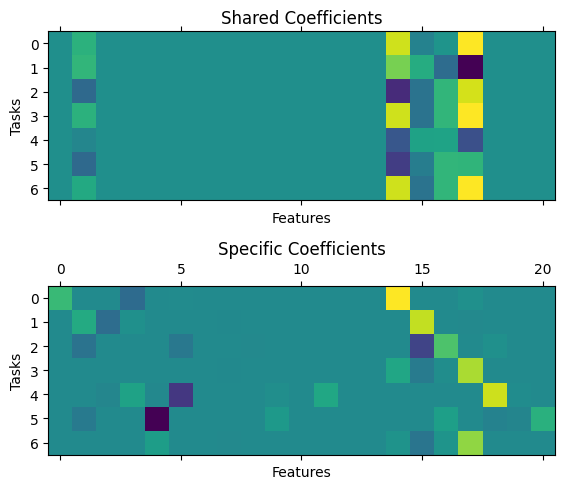

In [13]:
from mutar import DirtyModel

dl_model = DirtyModel(
    alpha=0.1,  # shared penalty
    beta=0.0442,  # task-specific penalty
)
dl_model.fit(x_train, y_train)

dl_plot(dl_model)

dl_res = score_dl(dl_model, x_train, y_train, x_val, y_val, x_test, y_test)
display(dl_res.round(3))

In [14]:
vpart_params = (
    {"n_partitions": 100, "n_cells": 8},
    {
        "max_iters": 1000,
        "lam_core": 0.38,
        "lam_task": 0.15,
        "core_alpha": 0.0,
        "task_alpha": 0.0,
        "print_epochs": 10,
        "mu": 0.1,
    },
)

jp_model = MTJOPLEn(
    GBPartition,
    # VPartition,
    **vpart_params[0],
    random_state=0,
)
history = jp_model.fit(
    x_train,
    y_train,
    lst_val_x=x_val,
    lst_val_y=y_val,
    **vpart_params[1],
    verbose=True,
)

KeyboardInterrupt: 

,train,val,test
task 0,0.084,0.083,0.081
task 1,0.087,0.086,0.084
task 2,0.075,0.077,0.071
task 3,0.055,0.057,0.054
task 4,0.120,0.125,0.123
task 5,0.159,0.162,0.153
task 6,0.072,0.072,0.071


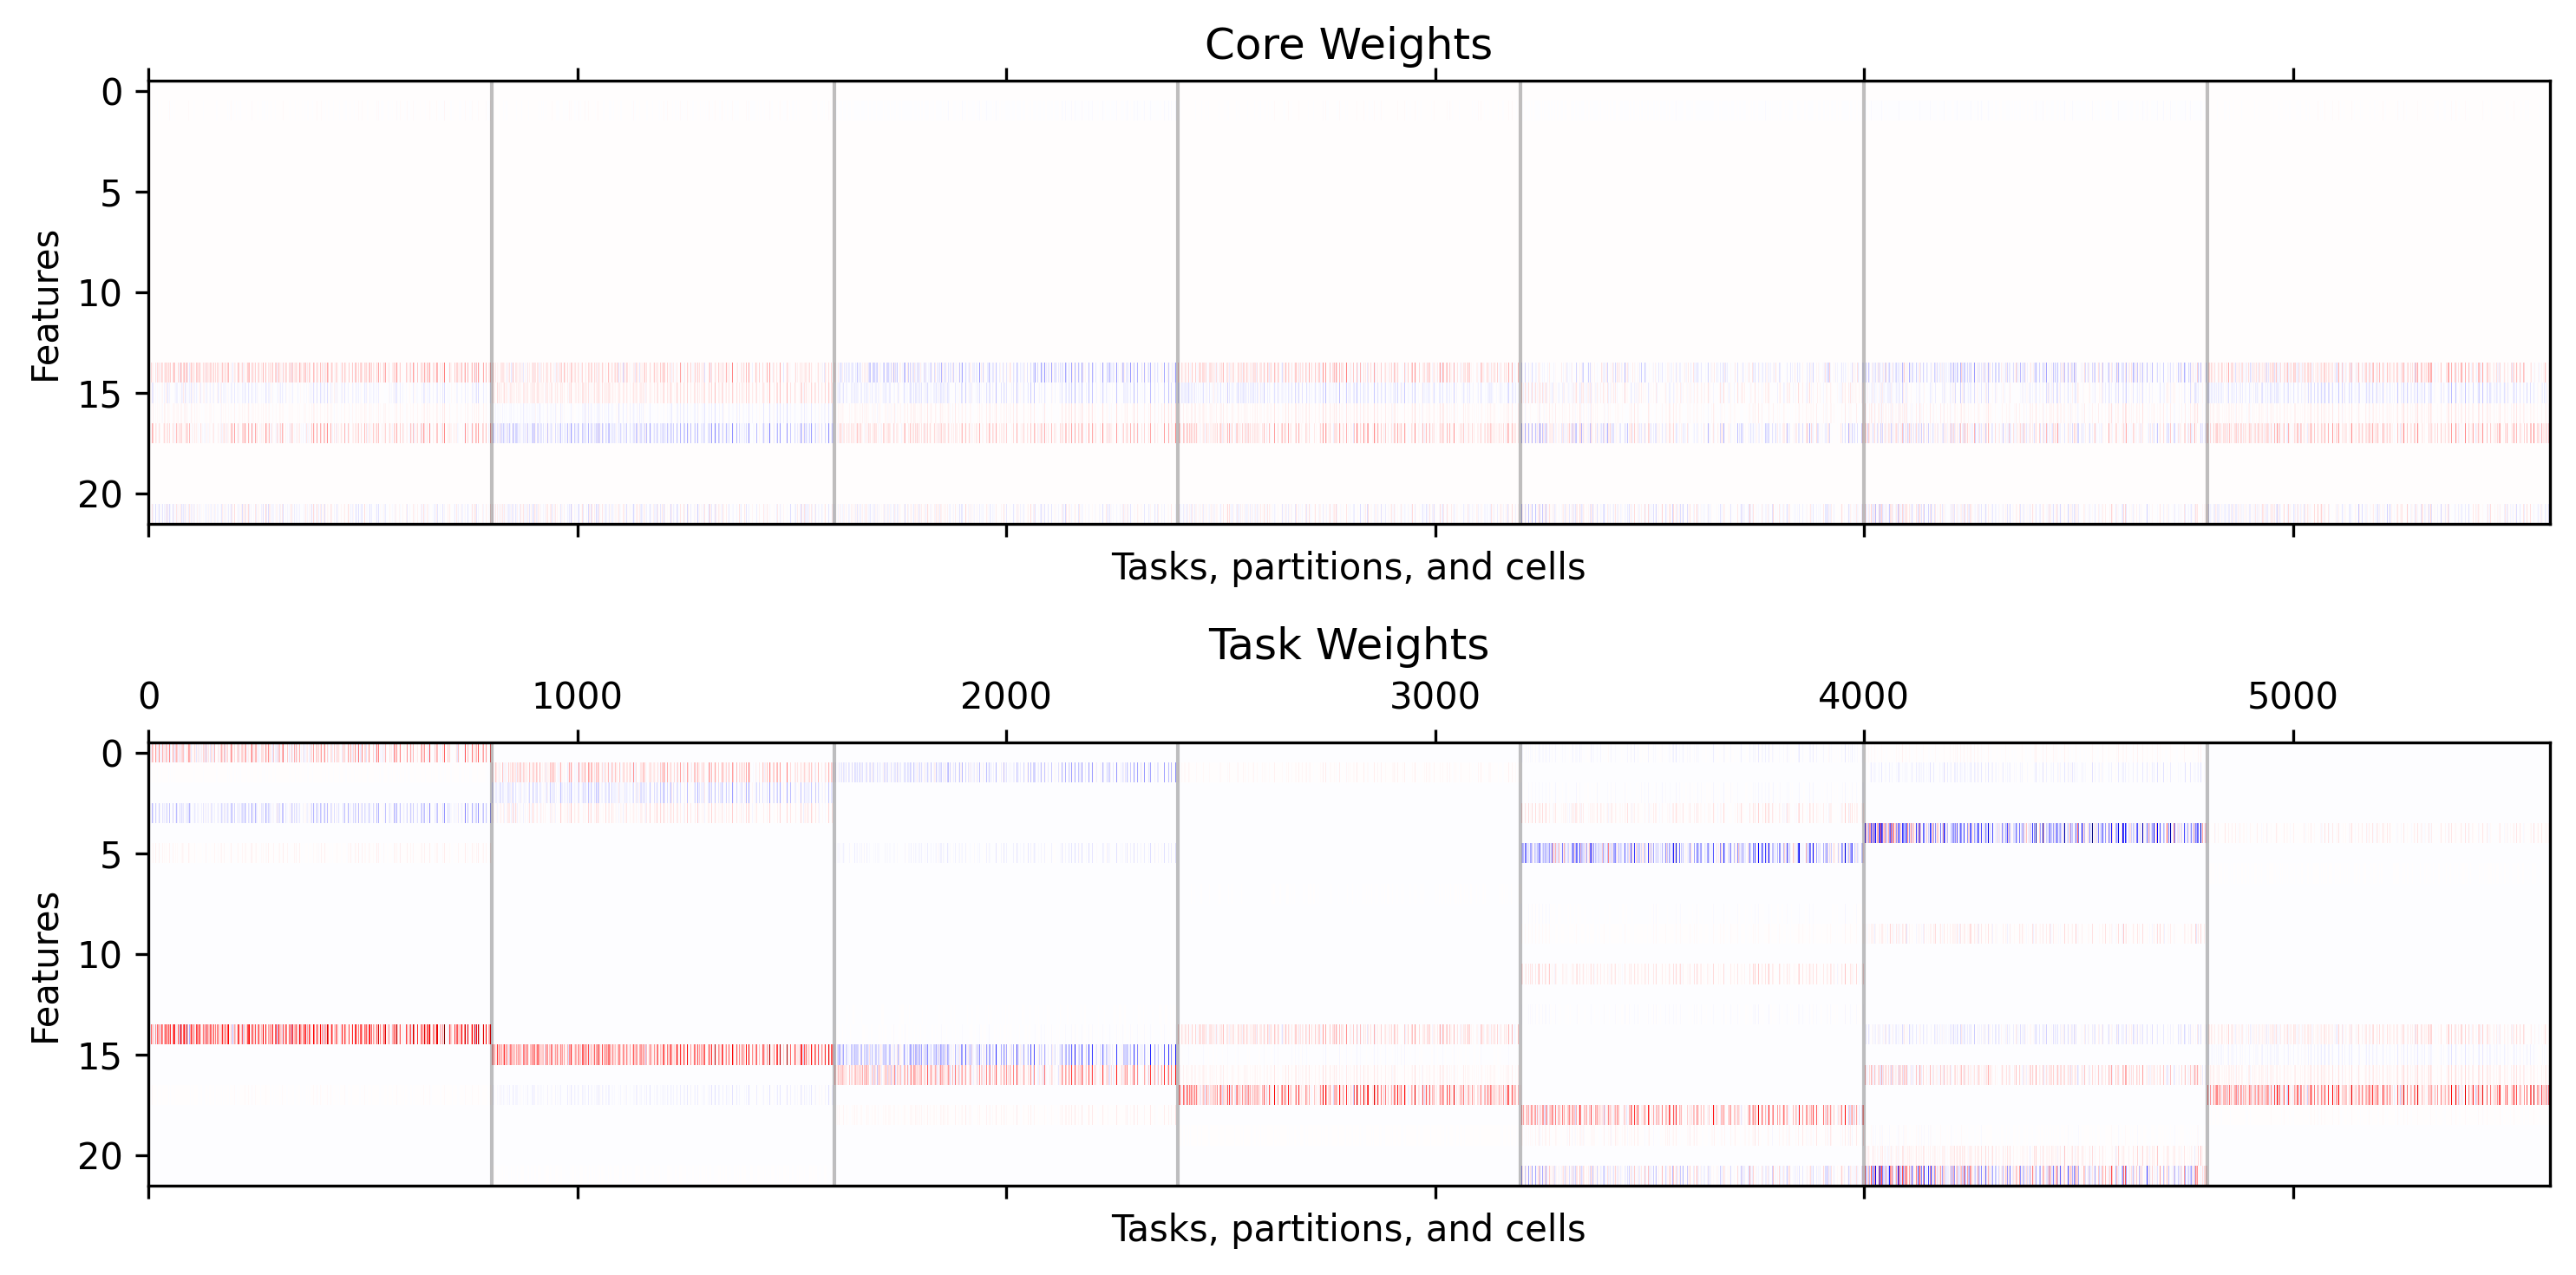

Number of nonzero core weights: 5
Number of nonzero task weights: [3, 2, 3, 2, 10, 5, 3]: 28


In [ ]:
jp_res = score_jp(jp_model, x_train, y_train, x_val, y_val, x_test, y_test)

display(jp_res.round(3))

plot_joplen_weights(jp_model)

In [ ]:
sarcos_df = compare_feats(
    jp_model, dl_model, x_train, y_train, x_val, y_val, x_test, y_test
)
sarcos_df.xs("test", level=1).round(3)

,0,1,2,3,4,5,6
joplen,0.025,0.024,0.019,0.01,0.024,0.035,0.017
dl,0.025,0.021,0.019,0.01,0.022,0.036,0.016


---

##### Parkinsons

In [15]:
# try parkinsons

train = {}
val = {}
test = {}

for dir in sorted(PARKINSONS_PATH.iterdir(), key=lambda x: int(x.name)):
    x_train = np.loadtxt(dir / "x_train.csv", delimiter=",")
    x_val = np.loadtxt(dir / "x_val.csv", delimiter=",")
    x_test = np.loadtxt(dir / "x_test.csv", delimiter=",")

    x_ss = StandardScaler()
    x_train = x_ss.fit_transform(x_train)
    x_val = x_ss.transform(x_val)
    x_test = x_ss.transform(x_test)

    y_train = np.loadtxt(dir / "y_train.csv", delimiter=",")[:, None]
    y_val = np.loadtxt(dir / "y_val.csv", delimiter=",")[:, None]
    y_test = np.loadtxt(dir / "y_test.csv", delimiter=",")[:, None]

    y_ss = StandardScaler()
    y_train = y_ss.fit_transform(y_train).flatten()
    y_val = y_ss.transform(y_val).flatten()
    y_test = y_ss.transform(y_test).flatten()

    train[int(dir.name)] = {"x": x_train, "y": y_train}
    val[int(dir.name)] = {"x": x_val, "y": y_val}
    test[int(dir.name)] = {"x": x_test, "y": y_test}

# print number of features and samples
print(x_train.shape)

(105, 18)


In [16]:
n_tasks = len(train)
participants = list(train.keys())

x_train = [train[i]["x"] for i in participants]
x_val = [val[i]["x"] for i in participants]
x_test = [test[i]["x"] for i in participants]

y_train = [train[i]["y"] for i in participants]
y_val = [val[i]["y"] for i in participants]
y_test = [test[i]["y"] for i in participants]

In [141]:
shared_params = {
    "x_train": x_train,
    "y_train": y_train,
    "x_val": x_val,
    "y_val": y_val,
    "x_test": x_test,
    "y_test": y_test,
}

dummy_results = train_model(DummyRegressor, **shared_params, strategy="mean")
linear_results = train_model(LinearRegression, **shared_params)
gb_results = train_model(
    LGBMRegressor,
    random_state=0,
    n_estimators=1000,
    verbose=-1,
    **shared_params,
)

print("Dummy Results")
display(dummy_results.round(3))
print("Linear Results")
display(linear_results.round(3))
print("GB Results")
display(gb_results.round(3))

100%|██████████| 42/42 [00:01<00:00, 24.14it/s]

Dummy Results


,train,val,test
task 0,1.0,1.062,1.008
task 1,1.0,0.914,1.110
task 2,1.0,0.852,0.726
task 3,1.0,1.169,0.662
task 4,1.0,0.793,1.129
task 5,1.0,1.081,0.873
task 6,1.0,1.023,0.503
task 7,1.0,1.068,0.718
task 8,1.0,1.497,0.964
task 9,1.0,0.863,0.904


Linear Results


,train,val,test
task 0,0.684,1.086,1.411
task 1,0.693,0.564,0.693
task 2,0.664,1.462,0.971
task 3,0.504,0.796,0.572
task 4,0.677,1.208,0.857
task 5,0.565,2.131,1.006
task 6,0.677,1.210,0.325
task 7,0.867,1.173,0.858
task 8,0.798,1.341,0.971
task 9,0.692,1.059,1.145


GB Results


,train,val,test
task 0,0.015,1.503,0.799
task 1,0.043,0.969,1.009
task 2,0.005,0.755,1.558
task 3,0.032,1.306,0.788
task 4,0.007,1.416,1.431
task 5,0.010,1.529,0.734
task 6,0.020,1.619,0.717
task 7,0.075,1.380,1.812
task 8,0.062,1.673,0.873
task 9,0.014,1.559,0.898


In [138]:
from JOPLEn.partitioner import VPartition, RFPartition, GBPartition

jp_model = MTJOPLEn(
    GBPartition,
    n_partitions=100,
    # VPartition,
    # n_partitions=1000,
    n_cells=8,
    random_state=0,
)

history = jp_model.fit(
    x_train,
    y_train,
    lst_val_x=x_val,
    lst_val_y=y_val,
    max_iters=100,
    lam_core=4.7,
    lam_task=1.16,
    core_alpha=0.0,
    task_alpha=0.0,
    print_epochs=2,
    mu=0.05,
)

[10:40:15]: Epoch      2 | TrL: 0.969405, 0.966758, 0.955875, 0.954244, 0.964828, 0.967680, 0.971596, 0.992809, 0.980080, 0.979592, 0.967738, 0.979311, 0.963981, 0.977855, 0.875615, 0.949638, 0.981795, 0.957780, 0.979305, 0.985728, 0.974347, 0.977865, 0.935085, 0.979000, 0.957522, 0.963164, 0.950352, 0.983195, 0.972010, 0.980588, 0.971886, 0.964633, 0.958248, 0.974681, 0.984913, 0.980585, 0.877886, 0.990318, 0.987431, 0.982925, 0.981537, 0.942387 | VaL: 1.012316, 0.920942, 0.881843, 1.084556, 0.905314, 1.001650, 1.001629, 1.025716, 1.215031, 0.919087, 1.049042, 1.034802, 0.939955, 1.046621, 1.063117, 1.129363, 0.997944, 0.880278, 0.944066, 1.089679, 0.992857, 0.998445, 0.860914, 1.163477, 1.069503, 0.970538, 1.015639, 1.384291, 0.878752, 0.941253, 1.006054, 0.999544, 0.937078, 1.089767, 1.052770, 0.994708, 0.972680, 0.901832, 1.044132, 1.295485, 1.019888, 1.031676 | CNorm: 8.610773 | TNorm: 29.685709 | CFNorm: 0.025170 | TFNorm: 0.025170 | WbNz:   17 | WsNz:    0,    0,    0,    0,    

,train,val,test
task 0,0.895,1.022,1.038
task 1,0.932,0.844,1.043
task 2,0.894,0.761,0.694
task 3,0.906,1.129,0.604
task 4,0.945,0.796,1.092
task 5,0.899,0.992,0.741
task 6,0.928,0.988,0.490
task 7,0.964,1.028,0.718
task 8,0.952,1.482,0.943
task 9,0.952,0.842,0.890


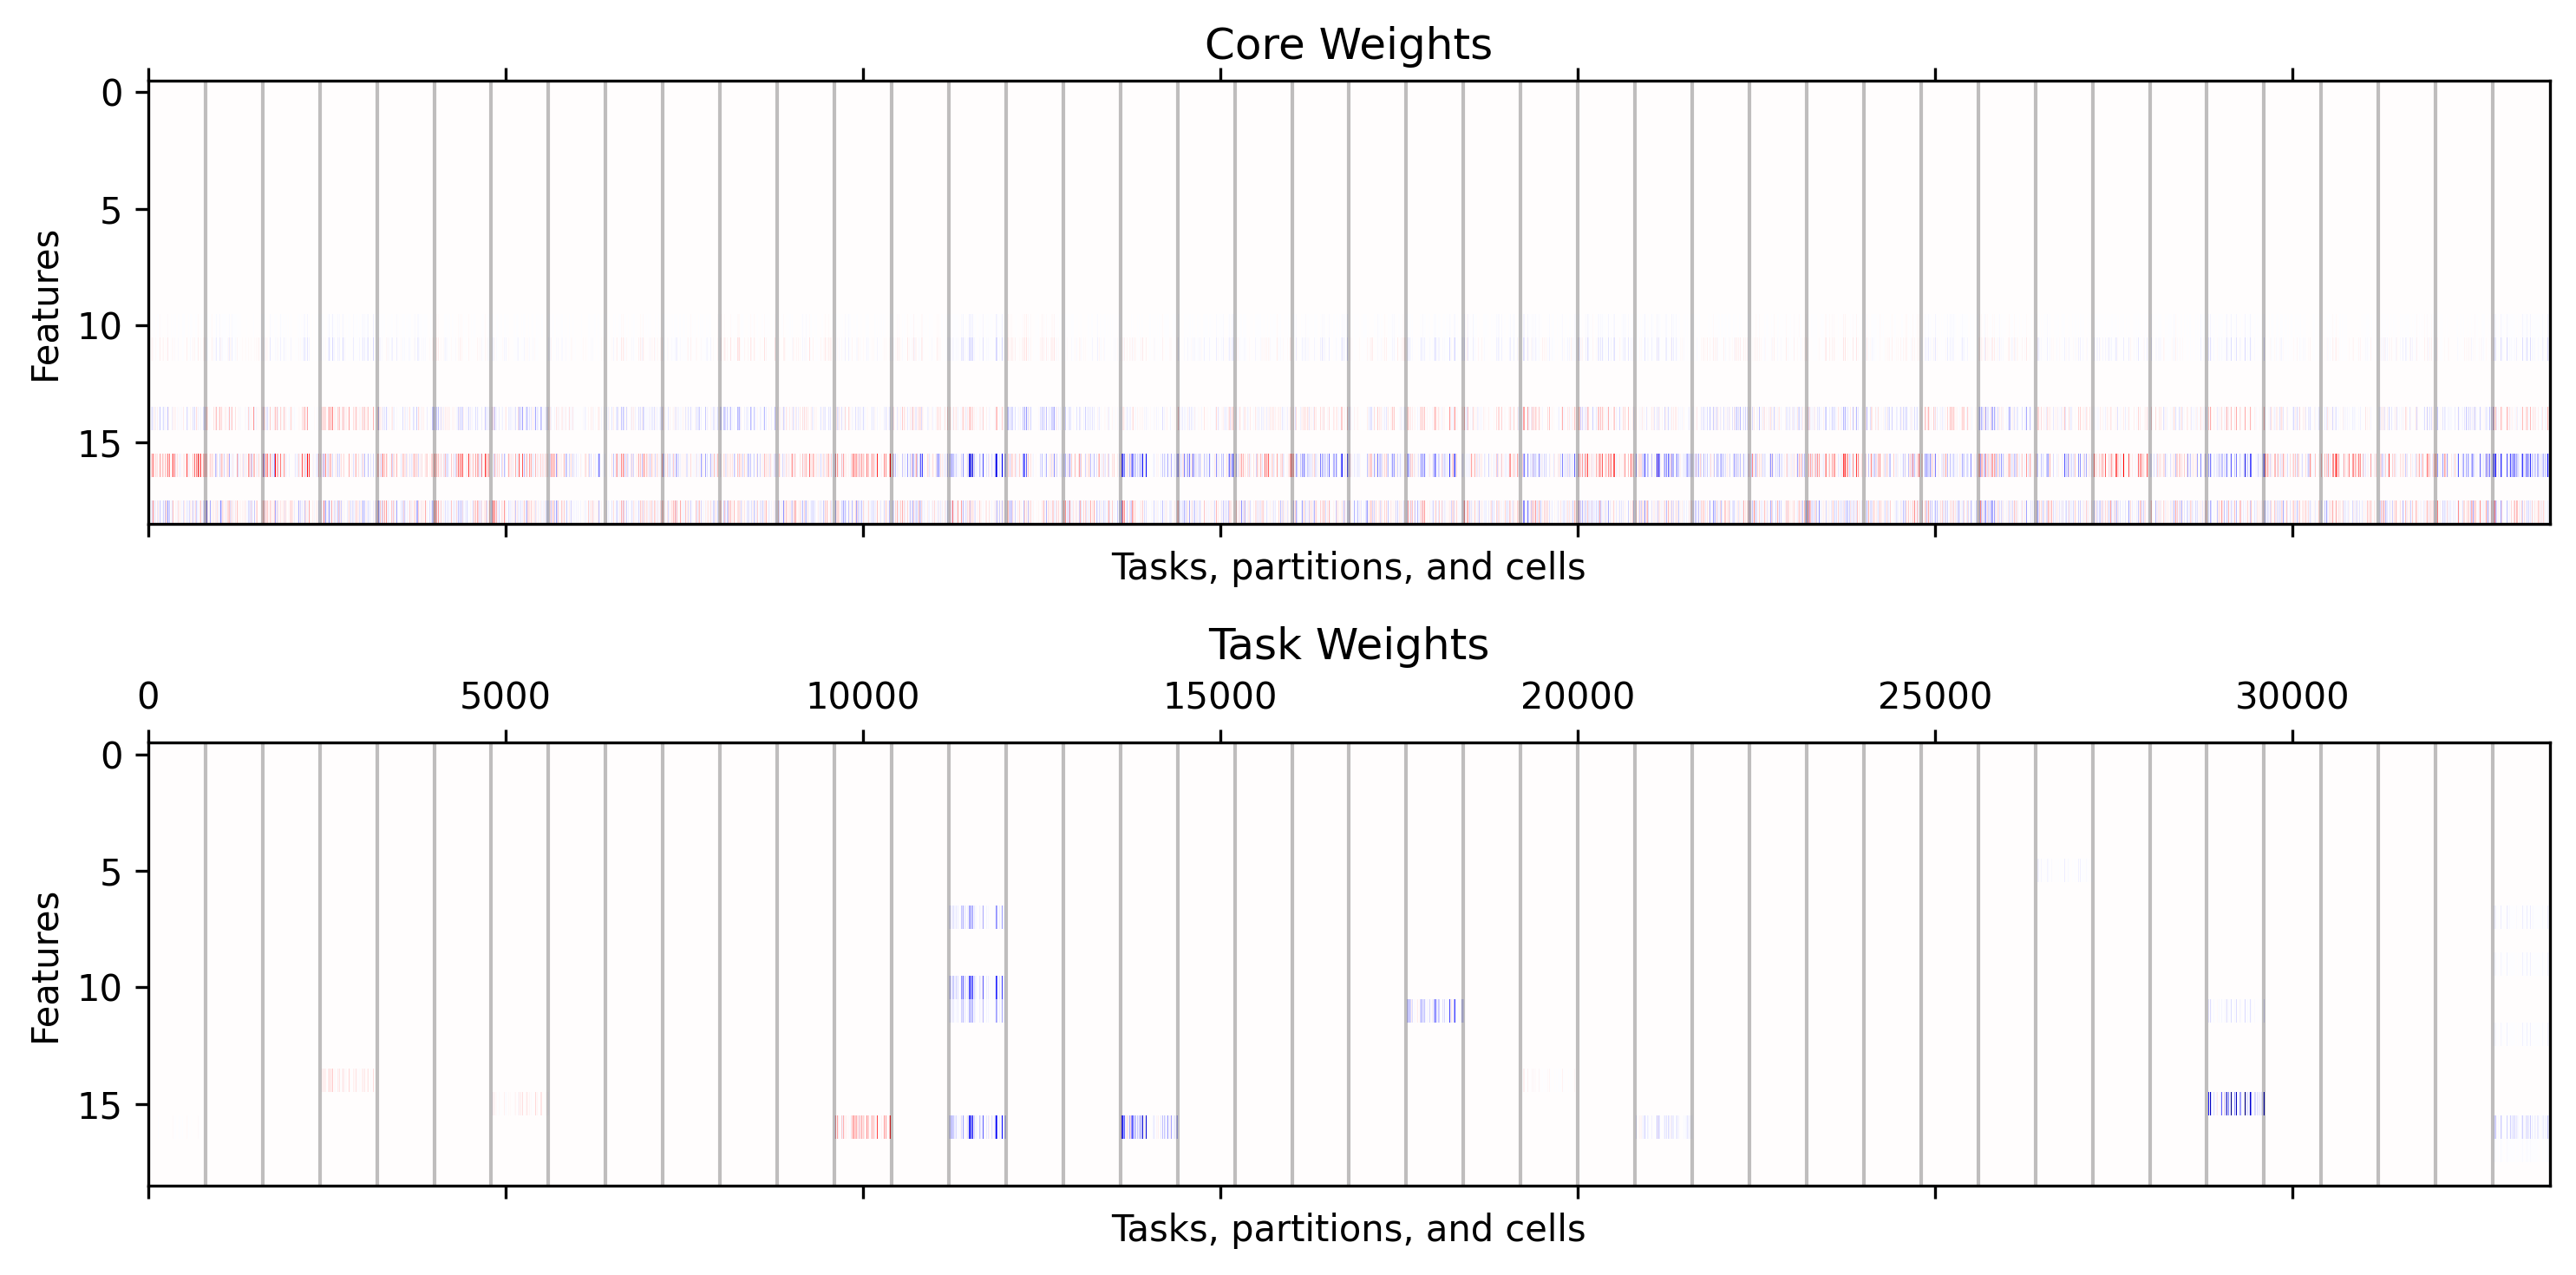

Number of nonzero core weights: 4
Number of nonzero task weights: [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 4]: 8


In [162]:
jp_res = score_jp(jp_model, x_train, y_train, x_val, y_val, x_test, y_test)

display(jp_res.round(3))

plot_joplen_weights(jp_model)

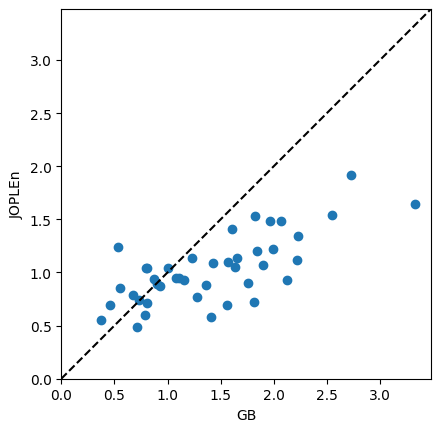

In [146]:
scatter_test(gb_results, jp_res, "GB", "JOPLEn")

In [43]:
from mutar import DirtyModel

x_train_out, y_train_out, train_mask_out = concat_datasets(x_train, y_train)
x_val_out, y_val_out, val_mask_out = concat_datasets(x_val, y_val)
x_test_out, y_test_out, test_mask_out = concat_datasets(x_test, y_test)

dl_model = DirtyModel(
    alpha=0.015,  # shared penalty
    beta=0.005,  # task-specific penalty
)
dl_model.fit(x_train_out, y_train_out, train_mask_out)

DirtyModel(alpha=0.015, beta=0.005)

Core features: 4
Task features: [0, 0, 0, 0, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]: 9


,train,val,test
task 0,0.822,0.996,1.183
task 1,0.899,0.726,0.808
task 2,0.851,0.713,0.705
task 3,0.838,1.039,0.627
task 4,0.893,0.836,1.018
task 5,0.848,0.930,0.650
task 6,0.875,0.908,0.445
task 7,0.988,1.001,0.732
task 8,0.960,1.437,0.952
task 9,0.919,0.861,0.800


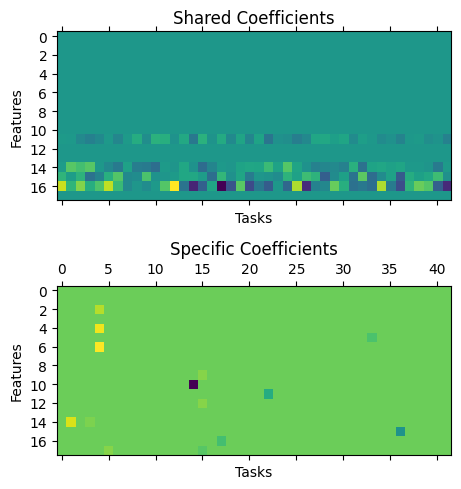

In [73]:
dl_plot(dl_model)

dl_res = score_dl(
    dl_model,
    x_train_out,
    y_train_out,
    x_val_out,
    y_val_out,
    x_test_out,
    y_test_out,
    masks=[train_mask_out, val_mask_out, test_mask_out],
)
display(dl_res.round(3))  # 4,9

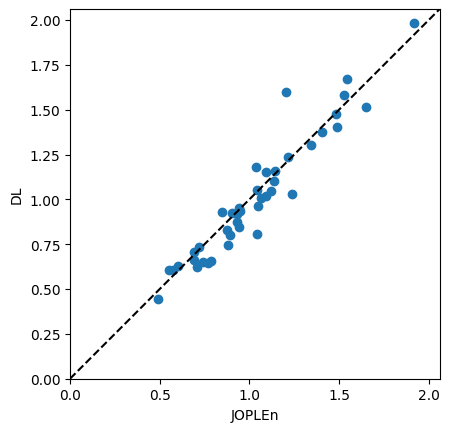

In [149]:
scatter_test(jp_res, dl_res, "JOPLEn", "DL")

In [151]:
feats_df = compare_feats(
    jp_model, dl_model, x_train, y_train, x_val, y_val, x_test, y_test
)
feats_df.xs("test", level=1).round(3)

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
joplen,0.979,1.106,0.72,0.589,1.057,0.819,0.408,0.715,0.943,0.886,...,0.89,1.357,1.179,0.998,1.687,1.127,0.735,1.419,0.798,1.461
dl,0.979,1.106,0.72,0.589,1.057,0.819,0.408,0.715,0.943,0.886,...,0.89,1.357,1.179,0.998,1.687,1.127,0.735,1.419,0.798,1.461


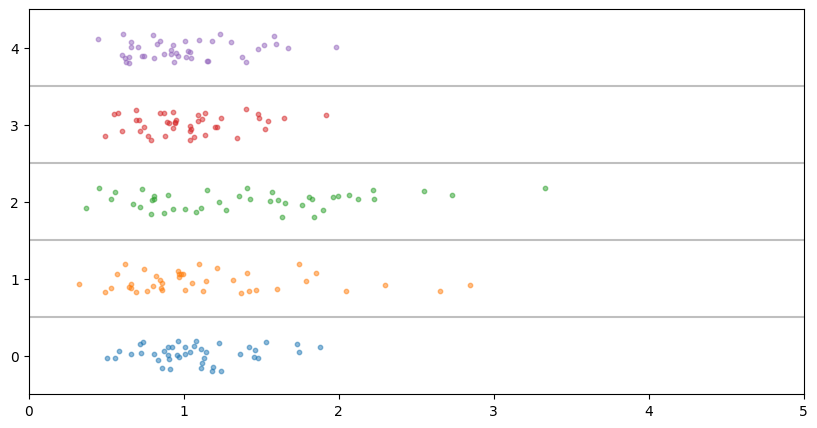

In [165]:
scores = [dummy_results, linear_results, gb_results, jp_res, dl_res]
scores = np.array([s["test"].to_numpy() for s in scores])

plot_strip(
    scores,
    plot_kwargs={"figsize": (10, 5)},
    scatter_kwargs={"alpha": 0.5, "s": 10},
)

plt.xlim(0, 5)

plt.show()

---

##### Nanoparticle

In [ ]:
train = {}
val = {}
test = {}

dirs = sorted(NANO_PATH.iterdir())
dir_names = [dir.name for dir in dirs]

for dir in dirs:
    x_train = np.loadtxt(dir / "x_train.csv", delimiter=",")
    x_val = np.loadtxt(dir / "x_val.csv", delimiter=",")
    x_test = np.loadtxt(dir / "x_test.csv", delimiter=",")

    x_ss = StandardScaler()
    x_train = x_ss.fit_transform(x_train)
    x_val = x_ss.transform(x_val)
    x_test = x_ss.transform(x_test)

    y_train = np.loadtxt(dir / "y_train.csv", delimiter=",")[:, None]
    y_val = np.loadtxt(dir / "y_val.csv", delimiter=",")[:, None]
    y_test = np.loadtxt(dir / "y_test.csv", delimiter=",")[:, None]

    y_ss = StandardScaler()
    y_train = y_ss.fit_transform(y_train).flatten()
    y_val = y_ss.transform(y_val).flatten()
    y_test = y_ss.transform(y_test).flatten()

    train[dir.name] = {"x": x_train, "y": y_train}
    val[dir.name] = {"x": x_val, "y": y_val}
    test[dir.name] = {"x": x_test, "y": y_test}

In [ ]:
n_tasks = len(train)
participants = list(train.keys())

x_train = [train[i]["x"] for i in participants]
x_val = [val[i]["x"] for i in participants]
x_test = [test[i]["x"] for i in participants]

y_train = [train[i]["y"] for i in participants]
y_val = [val[i]["y"] for i in participants]
y_test = [test[i]["y"] for i in participants]

In [ ]:
jp_model = MTJOPLEn(
    # GBPartition,
    # n_partitions=100,
    VPartition,
    n_partitions=100,
    n_cells=2,
    random_state=0,
)

history = jp_model.fit(
    x_train,
    y_train,
    lst_val_x=x_val,
    lst_val_y=y_val,
    max_iters=10000,
    # lam_core=8,
    # lam_task=100,
    lam_core=0.4,
    lam_task=0.3,
    core_alpha=0.0,
    task_alpha=0.0,
    print_epochs=100,
    mu=0.003,
    norm_type=NormType.L21,
    threshold=1e-4,
)

# 8
# [ 0 20 81 10  0  0  0]
# Train: [0.17, 0.09, 0.19, 0.08, 0.3, 0.28, 0.33]
# Val:   [0.57, 0.33, 0.29, 0.4, 0.46, 1.06, 0.77]
# Test:  [0.63, 0.28, 0.29, 0.38, 0.57, 0.63, 0.86]

[09:34:21]: Epoch    100 | TrL: 0.867186, 0.784022, 0.679030, 0.809682, 0.947097, 0.928715, 0.966590 | VaL: 0.847988, 0.735201, 0.680992, 0.824206, 1.028018, 1.194365, 0.982616 | CNorm: 19.221792 | TNorm: 9.429960 | CFNorm: 0.006786 | TFNorm: 0.006786 | WbNz:  402 | WsNz:    0,    0,   28,    0,    0,    0,    0
[09:34:22]: Epoch    200 | TrL: 0.862877, 0.776225, 0.672868, 0.799004, 0.940122, 0.921592, 0.963549 | VaL: 0.843277, 0.726383, 0.674874, 0.812894, 1.022277, 1.193385, 0.980105 | CNorm: 20.289038 | TNorm: 8.212170 | CFNorm: 0.009019 | TFNorm: 0.009019 | WbNz:  334 | WsNz:    0,    0,   30,    0,    0,    0,    0
[09:34:22]: Epoch    300 | TrL: 0.859945, 0.769949, 0.670408, 0.793114, 0.933750, 0.918050, 0.961584 | VaL: 0.841289, 0.720981, 0.672924, 0.806249, 1.016920, 1.192138, 0.978549 | CNorm: 21.058338 | TNorm: 7.520025 | CFNorm: 0.010481 | TFNorm: 0.010481 | WbNz:  276 | WsNz:    0,    0,   38,    0,    0,    0,    0
[09:34:22]: Epoch    400 | TrL: 0.858981, 0.766380, 0.6691

In [ ]:
jp_model = MTJOPLEn(
    LinearForestPartition,
    n_partitions=10,
    n_cells=4,
    random_state=0,
)

history = jp_model.fit(
    x_train,
    y_train,
    lst_val_x=x_val,
    lst_val_y=y_val,
    max_iters=10000,
    # lam_core=8,
    # lam_task=100,
    lam_core=0.8,
    lam_task=0.5,
    core_alpha=0.0,
    task_alpha=0.0,
    print_epochs=100,
    mu=0.003,
    norm_type=NormType.LINF1,
    threshold=1e-4,
)

/home/matt/code/school/joplen/code/joplen-tests/my_env/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/matt/code/school/joplen/code/joplen-tests/my_env/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/matt/code/school/joplen/code/joplen-tests/my_env/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the p

[09:08:31]: Epoch    100 | TrL: 0.799105, 0.691799, 0.667390, 0.763686, 0.802371, 0.842466, 0.915956 | VaL: 0.802098, 0.669733, 1.723345, 0.777802, 0.902139, 1.124071, 0.935927 | CNorm: 11.728550 | TNorm: 0.817025 | CFNorm: 0.003545 | TFNorm: 0.003545 | WbNz: 1058 | WsNz:    0,    0,    0,    0,    0,    0,    0
[09:08:32]: Epoch    200 | TrL: 0.773697, 0.662072, 0.653315, 0.736892, 0.758263, 0.816031, 0.900333 | VaL: 0.783820, 0.654050, 1.859746, 0.749227, 0.864157, 1.095738, 0.923113 | CNorm: 13.836845 | TNorm: 0.661705 | CFNorm: 0.003804 | TFNorm: 0.003804 | WbNz: 1007 | WsNz:    0,    0,    0,    0,    0,    0,    0
[09:08:33]: Epoch    300 | TrL: 0.760031, 0.644936, 0.646822, 0.723538, 0.732649, 0.801113, 0.892130 | VaL: 0.774938, 0.645625, 1.887000, 0.735270, 0.843067, 1.079471, 0.916401 | CNorm: 14.986124 | TNorm: 0.575601 | CFNorm: 0.003928 | TFNorm: 0.003928 | WbNz:  952 | WsNz:    0,    0,    0,    0,    0,    0,    0
[09:08:33]: Epoch    400 | TrL: 0.751468, 0.634375, 0.6417

KeyboardInterrupt: 

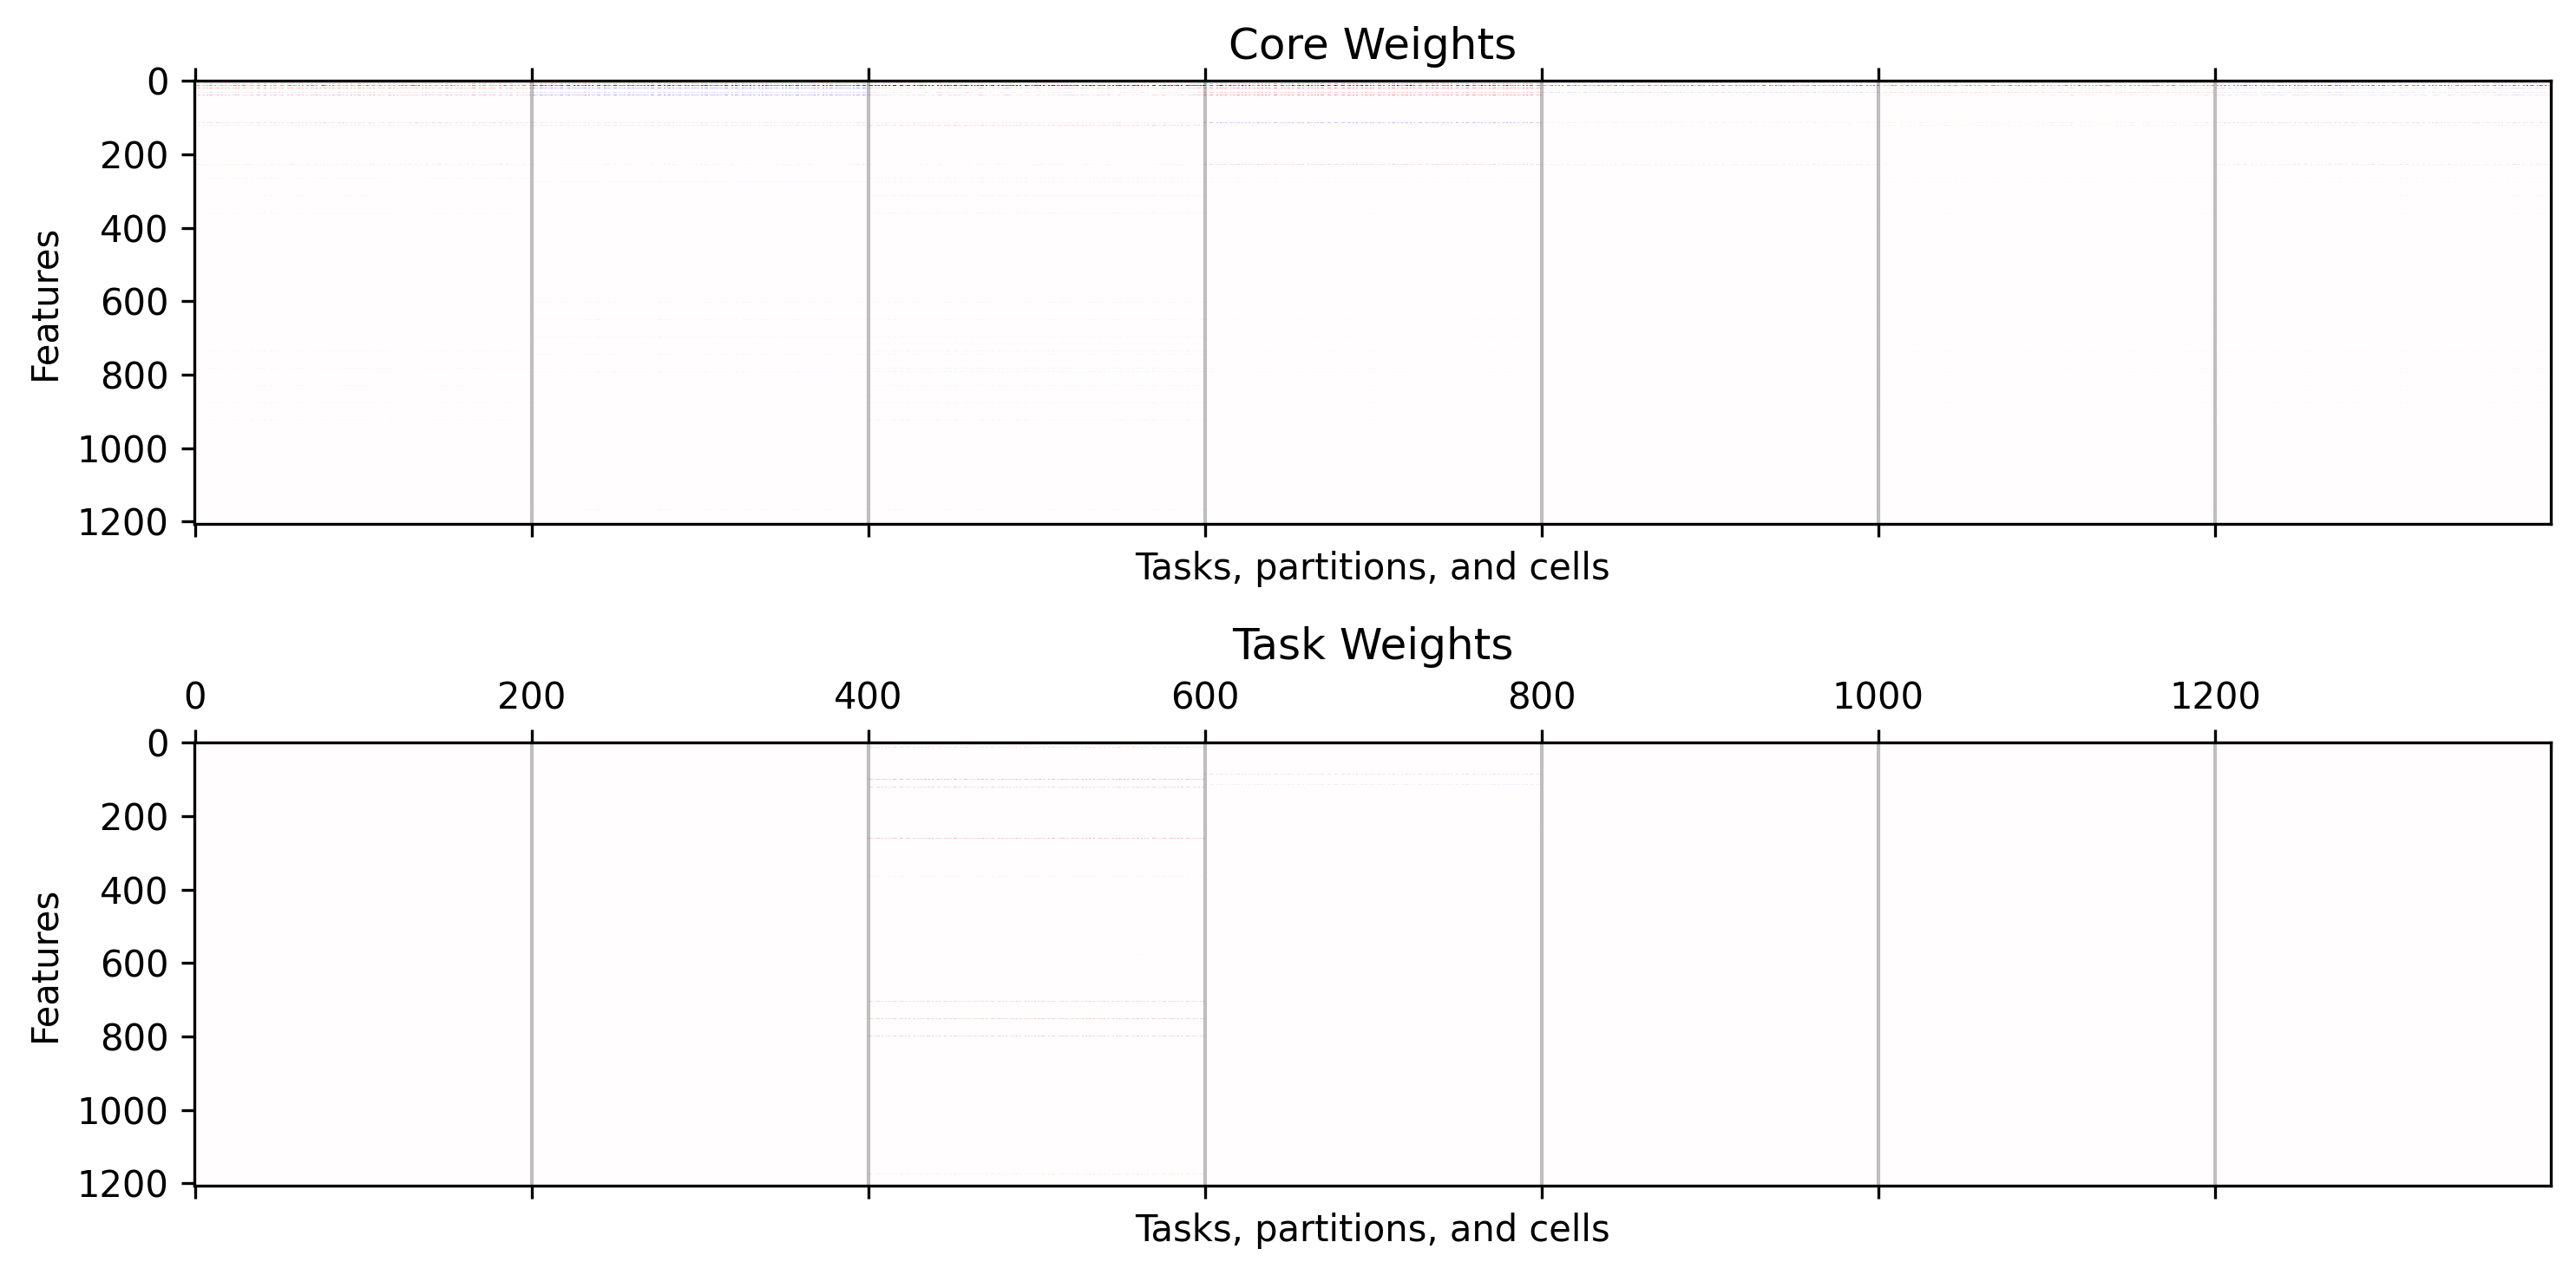

In [ ]:
plot_joplen_weights(jp_model)

In [ ]:
feature_mask = np.linalg.norm(jp_model.cwb.get(), axis=(0, 2))[:-1] > 1e-2
task_mask = np.linalg.norm(jp_model.cws.get(), axis=2)[:, :-1] > 1e-2
task_mask = task_mask & ~feature_mask
print(feature_mask.sum())
print(task_mask.sum(axis=1))

y_train_pred, y_val_pred, y_test_pred = [], [], []
y_train_err, y_val_err, y_test_err = [], [], []

for i in range(n_tasks):
    combined_mask = feature_mask | task_mask[i]

    lgbm = LGBMRegressor(random_state=0, verbose=-1)
    lgbm.fit(x_train[i][:, combined_mask], y_train[i])

    y_train_pred.append(lgbm.predict(x_train[i][:, combined_mask]))
    y_val_pred.append(lgbm.predict(x_val[i][:, combined_mask]))
    y_test_pred.append(lgbm.predict(x_test[i][:, combined_mask]))

    y_train_err.append(np.mean((y_train_pred[-1] - y_train[i]) ** 2))
    y_val_err.append(np.mean((y_val_pred[-1] - y_val[i]) ** 2))
    y_test_err.append(np.mean((y_test_pred[-1] - y_test[i]) ** 2))

print("Train:", list(np.around(y_train_err, 2)))
print("Val:  ", list(np.around(y_val_err, 2)))
print("Test: ", list(np.around(y_test_err, 2)))

83
[ 0  0 16  1  0  0  0]
Train: [0.06, 0.03, 0.16, 0.06, 0.12, 0.06, 0.2]
Val:   [0.63, 0.27, 0.28, 0.36, 0.48, 0.51, 0.81]
Test:  [0.63, 0.22, 0.28, 0.35, 0.59, 0.4, 0.86]


In [ ]:
np.sum(feature_mask) + np.sum(task_mask)

100

In [ ]:
from mutar import DirtyModel

x_train_out, y_train_out, train_mask_out = concat_datasets(x_train, y_train)
x_val_out, y_val_out, val_mask_out = concat_datasets(x_val, y_val)
x_test_out, y_test_out, test_mask_out = concat_datasets(x_test, y_test)

dl_model = DirtyModel(
    alpha=0.03,  # shared penalty
    beta=0.02,  # task-specific penalty
)
dl_model.fit(x_train_out, y_train_out, train_mask_out)

/home/matt/code/school/joplen/code/joplen-tests/my_env/lib/python3.10/site-packages/mutar/solvers.py:44: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  warnings.warn('Objective did not converge.' +


DirtyModel(alpha=0.03, beta=0.02)

In [ ]:
dl_feature_mask = np.linalg.norm(dl_model.coef_shared_.T, axis=0) > 1e-4
dl_task_mask = np.abs(dl_model.coef_specific_.T) > 1e-4
dl_task_mask = dl_task_mask & ~dl_feature_mask
print(dl_feature_mask.sum())
print(dl_task_mask.sum(axis=1))

dl_train_pred, dl_val_pred, dl_test_pred = [], [], []
dl_train_err, dl_val_err, dl_test_err = [], [], []

for i in range(n_tasks):
    combined_mask = dl_feature_mask | dl_task_mask[i]

    lgbm = LGBMRegressor(random_state=0, verbose=-1)
    lgbm.fit(x_train[i][:, combined_mask], y_train[i])

    dl_train_pred.append(lgbm.predict(x_train[i][:, combined_mask]))
    dl_val_pred.append(lgbm.predict(x_val[i][:, combined_mask]))
    dl_test_pred.append(lgbm.predict(x_test[i][:, combined_mask]))

    dl_train_err.append(np.mean((dl_train_pred[-1] - y_train[i]) ** 2))
    dl_val_err.append(np.mean((dl_val_pred[-1] - y_val[i]) ** 2))
    dl_test_err.append(np.mean((dl_test_pred[-1] - y_test[i]) ** 2))

print("Train:", list(np.around(dl_train_err, 2)))
print("Val:  ", list(np.around(dl_val_err, 2)))
print("Test: ", list(np.around(dl_test_err, 2)))

# 79
# [ 2  0 87  6  0  0  5]
# Train: [0.05, 0.03, 0.13, 0.04, 0.1, 0.07, 0.18]
# Val:   [0.55, 0.24, 0.26, 0.34, 0.3, 0.42, 0.77]
# Test:  [0.58, 0.19, 0.24, 0.36, 0.6, 0.34, 0.81]
# 179

17
[ 0  0 85  7  0  0  1]
Train: [0.17, 0.09, 0.15, 0.09, 0.25, 0.24, 0.31]
Val:   [0.59, 0.35, 0.26, 0.39, 0.4, 0.97, 0.77]
Test:  [0.61, 0.26, 0.25, 0.39, 0.43, 0.79, 0.83]


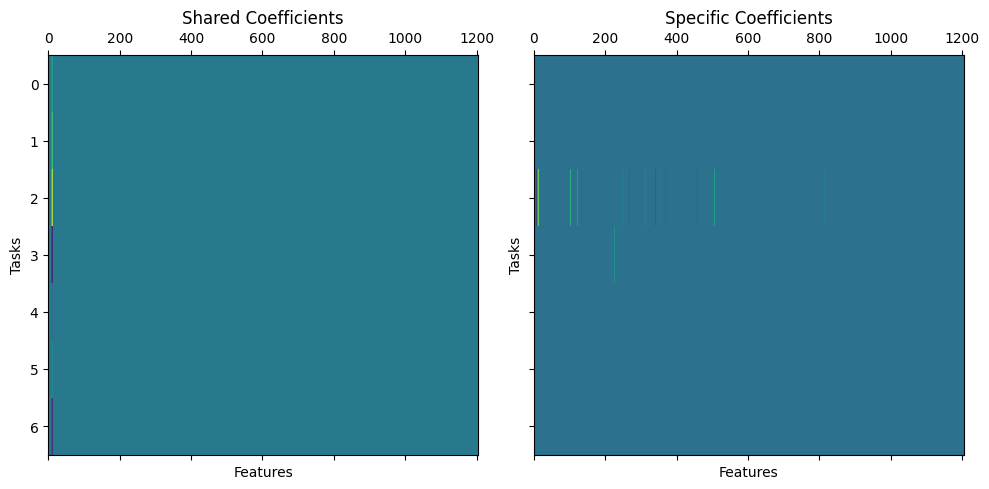

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True, sharex=True)

axs[0].matshow(dl_model.coef_shared_.T, aspect="auto")
axs[0].set_title("Shared Coefficients")

axs[1].matshow(dl_model.coef_specific_.T, aspect="auto")
axs[1].set_title("Specific Coefficients")

for ax in axs:
    ax.set_xlabel("Features")
    ax.set_ylabel("Tasks")

plt.tight_layout()
plt.show()

In [ ]:
np.sum(dl_feature_mask) + np.sum(dl_task_mask)

110

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor


def train_model(ModelClass, **kwargs):
    output = {}
    model = ModelClass(**kwargs)

    for i in tqdm(range(n_tasks)):
        model.fit(x_train[i], y_train[i])

        output[f"task {i}"] = {
            "train": np.mean((model.predict(x_train[i]) - y_train[i]) ** 2),
            "val": np.mean((model.predict(x_val[i]) - y_val[i]) ** 2),
            "test": np.mean((model.predict(x_test[i]) - y_test[i]) ** 2),
        }
    return output


linear_results = train_model(LinearRegression)
naive_results = train_model(DummyRegressor, strategy="mean")
lgbm_results = train_model(LGBMRegressor, random_state=0, verbose=-1)
linear_test_err = [linear_results[f"task {i}"]["test"] for i in range(n_tasks)]
naive_test_err = [naive_results[f"task {i}"]["test"] for i in range(n_tasks)]
lgbm_test_err = [lgbm_results[f"task {i}"]["test"] for i in range(n_tasks)]

100%|██████████| 7/7 [00:03<00:00,  1.88it/s]


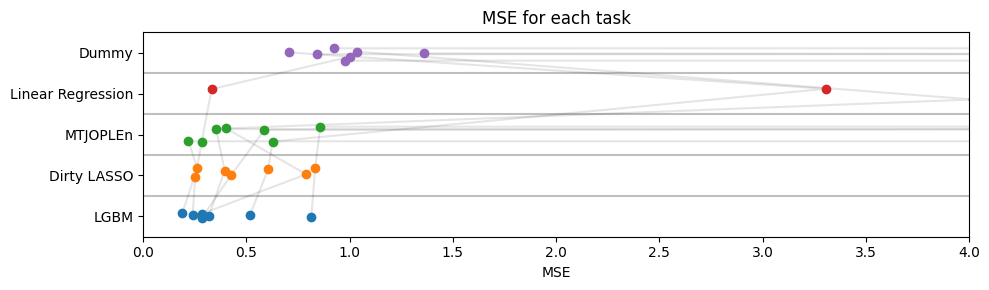

In [ ]:
columns = ["train", "val", "test"]
index = [f"task {i}" for i in range(n_tasks)]

data = np.vstack(
    [lgbm_test_err, dl_test_err, y_test_err, linear_test_err, naive_test_err]
)

fig, ax = plt.subplots(figsize=(10, 3))

ax, y_values = plot_strip(
    data,
    scatter_kwargs={"marker": "o"},
    ax=ax,
)

ax.plot(data.reshape(5, -1), y_values, color="k", alpha=0.1, zorder=0)

ax.set_xlabel("MSE")
ax.set_yticks(
    range(5), ["LGBM", "Dirty LASSO", "MTJOPLEn", "Linear Regression", "Dummy"]
)
ax.set_title("MSE for each task")

ax.set_xlim(0, 4)
plt.tight_layout()
plt.show()

In [ ]:
path = NANO_PATH / "logp" / "metadata.yaml"
metadata = yaml.load(path.read_text(), Loader=yaml.SafeLoader)
features = np.array(metadata["features"])

print("JOPLEn features")
print(features[feature_mask])
print()
print("DirtyLasso Features")
print(features[dl_feature_mask])

JOPLEn features
['mass_whim_rel_axis3' 'mass_whim_k' 'unweighted_cchn' 'mass_cchn'
 'vdw_volume_cchn' 'electronegativity_cchn' 'polarizability_cchn'
 'covalent_radius_cchn' 'electron_affinity_cchn' 'nvalence_cchn'
 'zeff_cchn' 'ionization_energy1_cchn' 'ionization_energy2_cchn'
 'ionization_energy3_cchn' 'melting_point_cchn' 'boiling_point_cchn'
 'thermal_conductivity_cchn' 'fusion_heat_cchn' 'evaporation_heat_cchn'
 'atomic_volume_cchn' 'density_cchn' 'specific_heat_cchn']

DirtyLasso Features
['vdw_volume_variance' 'electronegativity_variance'
 'electron_affinity_variance' 'ionization_energy1_variance'
 'mass_whim_rel_axis3' 'mass_whim_k' 'electron_affinity_whim_ax_density1'
 'vdw_volume_convhull_first_quartile'
 'electron_affinity_convhull_first_quartile' 'unweighted_cccc'
 'unweighted_ccch' 'unweighted_hhoo' 'mass_cccc' 'mass_ccch' 'mass_hhoo'
 'vdw_volume_cccc' 'vdw_volume_ccch' 'vdw_volume_hhoo'
 'electronegativity_ccch' 'polarizability_ccch' 'fusion_heat_hhhx']


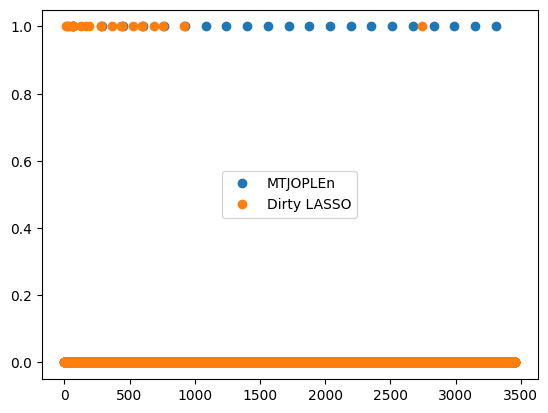

In [ ]:
plt.plot(feature_mask, "o", label="MTJOPLEn")
plt.plot(dl_feature_mask, "o", label="Dirty LASSO")
plt.legend()